# Image Segmentation of Handwritten Digits

<img src='https://drive.google.com/uc?export=view&id=1-WBX7w_R9abwdGmAUBFWWEcJ0LkMppq2' alt='m2nist digits'>

## Imports

In [25]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

from google.colab import drive, files

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


## Download the dataset

In [28]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip \
    -O /tmp/m2nist.zip

local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2022-03-06 18:10:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 2404:6800:4008:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  --.-KB/s    in 0.1s    

2022-03-06 18:10:43 (128 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



## Load and Preprocess the Dataset

In [29]:
BATCH_SIZE = 64

def read_image_and_annotation(image, annotation):
  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


#### load the preprocessed dataset and define the training, validation, and test sets.

In [30]:
train_slices, val_slices, test_slices = load_images_and_segments()

training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

#### visualazing the data set

In [31]:
n_classes = 11

colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


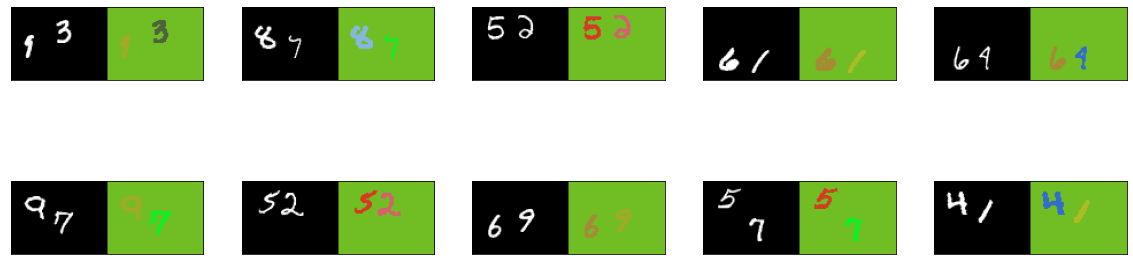

In [32]:
list_show_annotation(training_dataset, 10)

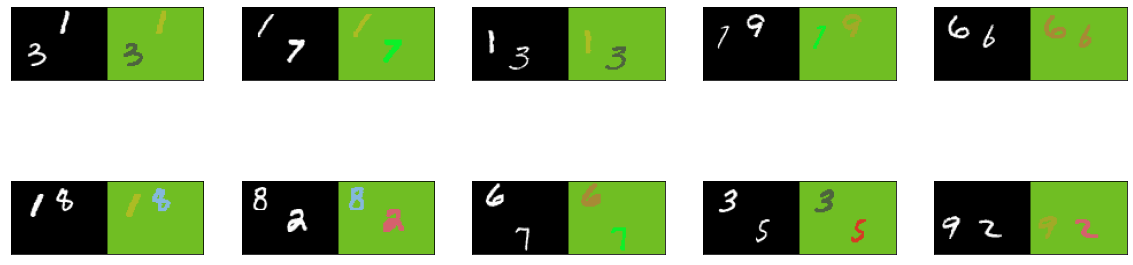

In [33]:
list_show_annotation(validation_dataset, 10)

## Define the Model

In [34]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pooling_size, pool_strides, padding='same', data_format=IMAGE_ORDERING)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  return x

In [ ]:
test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

del test_input, test_output, test_model

### Define the Downsampling Path

In [36]:
def FCN8(input_height=64, input_width=84):   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96 - input_width)))(img_input)
    filter_size = 32
    kernel_size = (3, 3)
    pooling_size = 2
    pool_strides = 2

    x = conv_block(x, filter_size, kernel_size, pooling_size, pool_strides)
    x = conv_block(x, filter_size * (2 ** 1), kernel_size, pooling_size, pool_strides)

    x = conv_block(x, filter_size * (2 ** 2), kernel_size, pooling_size, pool_strides)
    f3 = x

    x = conv_block(x, filter_size * (2 ** 3), kernel_size, pooling_size, pool_strides)
    f4 = x

    x = conv_block(x, filter_size * (2 ** 3), kernel_size, pooling_size, pool_strides)
    f5 = x
  
    return (f3, f4, f5), img_input

In [ ]:
test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

### Define the FCN-8 decoder

In [38]:
def fcn8_decoder(convs, n_classes):
  f3, f4, f5 = convs

  n = 512

  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)

  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2))(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 0)))(o)

  o2 = f4
  o2 = tf.keras.layers.Conv2D(n_classes , (1 , 1) , activation='relu' , padding='same', name="conv8", data_format=IMAGE_ORDERING)(o2)

  o = tf.keras.layers.Add()([o, o2])

  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  o = tf.keras.layers.Add()([o, o2])

  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(2 ** 3, 2 ** 3), strides=(2 ** 3, 2 ** 3))(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o

In [39]:
test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


### Define the Complete Model

In [40]:
convs, img_input = FCN8()

dec_op = fcn8_decoder(convs, n_classes)

model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [ ]:
model.summary()

## Compile the Model

In [42]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [43]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

## Model Training

#### mount google drive.

In [44]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#### configure checkpoints.

In [45]:
checkpoint_filepath = '/content/drive/My Drive/coursera/image_segmentation/model.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

#### Load model weights.

In [63]:
model.load_weights(checkpoint_filepath)

In [64]:
EPOCHS = 100

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
62/62 [==============================] - 14s 225ms/step - loss: 0.1237 - accuracy: 0.9591 - val_loss: 0.1257 - val_accuracy: 0.9585
Epoch 2/100
62/62 [==============================] - 15s 239ms/step - loss: 0.1224 - accuracy: 0.9596 - val_loss: 0.1246 - val_accuracy: 0.9585
Epoch 3/100
62/62 [==============================] - 14s 235ms/step - loss: 0.1210 - accuracy: 0.9601 - val_loss: 0.1226 - val_accuracy: 0.9594
Epoch 4/100
62/62 [==============================] - 14s 232ms/step - loss: 0.1192 - accuracy: 0.9608 - val_loss: 0.1213 - val_accuracy: 0.9600
Epoch 5/100
62/62 [==============================] - 15s 237ms/step - loss: 0.1180 - accuracy: 0.9613 - val_loss: 0.1197 - val_accuracy: 0.9604
Epoch 6/100
62/62 [==============================] - 15s 236ms/step - loss: 0.1162 - accuracy: 0.9619 - val_loss: 0.1180 - val_accuracy: 0.9609
Epoch 7/100
62/62 [==============================] - 14s 234ms/step - loss: 0.1148 - accuracy: 0.9624 - val_loss: 0.1176 - val_accuracy:

KeyboardInterrupt: ignored

## Model Evaluation

In [65]:
results = model.predict(test_dataset, steps=test_steps)
print(results.shape)

(192, 64, 84, 11)


In [66]:
print(results[0,0,0,0])
print(results[0,0,0,10])

0.26580724
0.99950194


In [67]:
results = np.argmax(results, axis=3)
print(results.shape)

(192, 64, 84)


In [68]:
print(results[0,0,0])
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


In [69]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

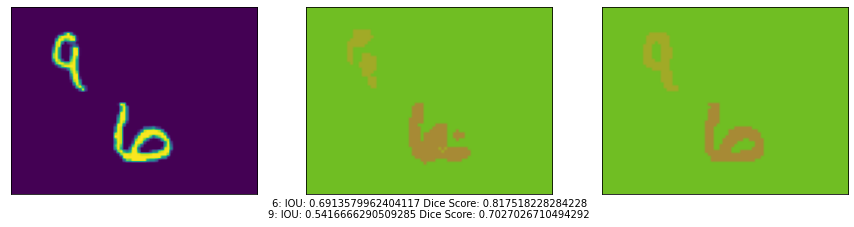

In [70]:
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


### Compute IOU Score and Dice Score of model

In [77]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("Score is " + str(grade))

PASSING_SCORE = 60
if (grade>PASSING_SCORE):
  print("test passed")
else:
  print("pPlease check model and re-train")

Digit 0: IOU: 0.6844604306698411 Dice Score: 0.8126761759522712
Digit 1: IOU: 0.786097849683479 Dice Score: 0.8802405196588601
Digit 2: IOU: 0.5734122706421827 Dice Score: 0.7288773341117347
Digit 3: IOU: 0.6451694478437412 Dice Score: 0.7843197534324983
Digit 4: IOU: 0.6190325128960626 Dice Score: 0.7646943566176584
Digit 5: IOU: 0.5663384895040812 Dice Score: 0.7231367846721174
Digit 6: IOU: 0.6541311328755332 Dice Score: 0.790906016910999
Digit 7: IOU: 0.7280312195827867 Dice Score: 0.8426135029650234
Digit 8: IOU: 0.6145532464226654 Dice Score: 0.7612672394475923
Digit 9: IOU: 0.6359126973612554 Dice Score: 0.7774408724707491
Score is 65.07139297481629
test passed


## Save the Model

In [72]:
model.save("model.h5")

In [78]:
from google.colab import files
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References
##### coursera - Advanced Computer Vision with TensorFlow [course](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/).